In [87]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
import numpy as np
import random
import math
import EoN
import seaborn as sns
import time
import matplotlib.animation
from IPython.display import HTML


# New Imports
#from ctrace.contact_tracing import *
#from ctrace.constraint import *
#from ctrace.solve import *
#from ctrace.simulation import *
#from ctrace.restricted import *
from ctrace.simulation import *
from ctrace.dataset import *
from ctrace.recommender import *
from ctrace.problem_label import *
from ctrace.utils import *
from ctrace.drawing import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
# I1 = E
# I2 = I

# <==================== Style Registry ====================>

LARGE_NODE_RADIUS = 100
SMALL_NODE_RADIUS = 50
seir_node_style = {
    # Default styling
    "default": {
        "node_size": SMALL_NODE_RADIUS,
        "node_color": "black",
        "edgecolors": "black",
        "linewidths": 0.5,
    },
    "seir": {
        SEIR.E: {"node_size": LARGE_NODE_RADIUS, "node_color": "red"},
        SEIR.I: {"node_size": LARGE_NODE_RADIUS, "node_color": "darkred"},
        SEIR.R: {"node_size": LARGE_NODE_RADIUS, "node_color": "skyblue"},
    },
    "isolate": {
        True: {"edgecolors": "aqua", "linewidths": 1.5}
    },
#     "V1": {
#         True: {"node_size": 30, "node_color": "orange"},
#     }
}

seir_edge_style = {
    # connectionstyle and arrowstyle are function-wide parameters
    # NOTE: For limit the number of unique connectionstyle / arrowstyle pairs
    "default": {
        "edge_color": "black",
        "arrowstyle": "-",
    },
    "long": {
        False: {},
        True: {"connectionstyle": "arc3,rad=0.2"},
    },

    # Overriding (cut overrides transmission)
    "transmit": {
        False: {},
        True: {"edge_color": "red"},
    },
    "cut": {
        False: {},
        True: {"edge_color": "blue"},
    },
}

# <==================== Graph Registry ====================>
base_grid = {
    'max_norm': False,
    'sparsity': 0,
    'p': 1,
    'local_range': 1,
    'num_long_range': 0,
    'r': 2,
}

feature_grid = {
    'max_norm': True,
    'sparsity': 0.1,
    'p': 1,
    'local_range': 1,
    'num_long_range': 1,
    'r': 2,
}

100%|██████████| 100/100 [00:00<00:00, 5171.58it/s]


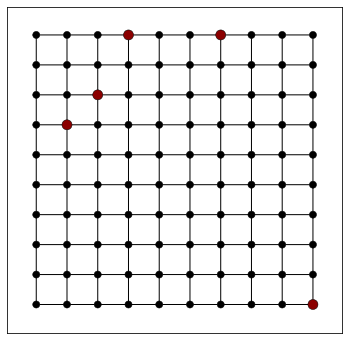

{32, 98, 3, 6, 7, 8, 9, 41, 13, 14, 21, 23, 89, 30}
Evens [32, 98, 6, 8, 14, 30]
Odds [3, 7, 9, 41, 13, 21, 23, 89]
{0: None, 1: None, 2: None, 3: None, 4: None}


In [100]:
seed=42
rng = np.random.default_rng(seed)

G, pos = small_world_grid(**base_grid, width=10, seed=seed)

for n in G.nodes:
    G.nodes[n].update({
        'compliance_rate_og': 1,
        'age_group': (n % 2) + 1,
    })
for e in G.edges:
    G.edges[e].update({
        'duration': 10000,
    })
    
i1_pct = 0.0
i2_pct = 0.1
seir = PartitionSEIR.from_dist(len(G), [1 - i1_pct - i2_pct, i1_pct, i2_pct, 0], rng=rng)

state = InfectionState(
    G=G, 
    SIR=(list(seir.S), list(seir.E), list(seir.I), list(seir.R)), 
    budget=14, 
    policy="A", 
    transmission_rate=0.15, 
    transmission_known=True, 
    compliance_rate=1, 
    compliance_known=True, 
    discovery_rate=1, 
    snitch_rate=1
)

fig, ax = plt.subplots(figsize=(6,6))
nx.set_node_attributes(G, seir.to_dict(), "seir")
fast_draw_style(G, seir_node_style,
           seir_edge_style, ax=ax, DEBUG=False)
plt.show()


state.set_budget_labels()
print(state.V1)
print('Evens', [v for v in state.V1 if G.nodes[v]["age_group"] == 1])
print('Odds', [v for v in state.V1 if G.nodes[v]["age_group"] == 2])
print(state.budget_labels)

In [101]:
import copy
raw_history = []
state_history = []
action_history = []

def pct_format(name, v1, v2):
    pct = f"{(v1 / v2) * 100:.1f}%" if v2 != 0 else "-%"
    return f"{name}: {v1}/{v2} ({pct})"

while len(state.SIR.I2) + len(state.SIR.I1)!=0:
    action = DegGreedy_fair(state)
    
    state_history.append(state.SIR)
    action_history.append(action)
    raw_history.append(copy.deepcopy(state))
    
    print(f"Budgets: {state.budget_labels}")
    print(f"Size (I1, I2, I): {(len(state.SIR.I1), len(state.SIR.I2), len(state.SIR.I1) + len(state.SIR.I2))}")
    print(f"V1 Size: {len(state.V1)}")
    print(f"V2 Size: {len(state.V2)}")
    print(pct_format("Budget Utilization", len(action), state.budget))
    print(pct_format("V1 Quarantined (out of V1)", len(action), len(state.V1)))
    print(pct_format("I1 Quarantined (out of Q)", len(set(state.SIR.I1) & set(action)), len(action)))
    print(f"I1: {state.SIR.I1}")
    print(f"I2: {state.SIR.I2}")
    print(f"V1: {state.V1}")
    print(f"V2: {state.V2}")
    print(f"Q: {action}")
    print("-----------------------------")
    
    # Mutable state
    state.step(action)

action_history.append(set())

Budgets: {0: None, 1: None, 2: None, 3: None, 4: None}
Size (I1, I2, I): (0, 5, 5)
V1 Size: 14
V2 Size: 16
Budget Utilization: 14/14 (100.0%)
V1 Quarantined (out of V1): 14/14 (100.0%)
I1 Quarantined (out of Q): 0/14 (0.0%)
I1: []
I2: [99, 5, 11, 22, 31]
V1: {32, 98, 3, 6, 7, 8, 9, 41, 13, 14, 21, 23, 89, 30}
V2: {33, 97, 1, 4, 40, 42, 10, 12, 15, 16, 79, 51, 20, 88, 24, 26}
Q: {32, 98, 3, 6, 7, 8, 41, 9, 13, 14, 21, 23, 89, 30}
-----------------------------
Budgets: {0: None, 1: None, 2: None, 3: None, 4: None}
Size (I1, I2, I): (2, 0, 2)
V1 Size: 0
V2 Size: 0
Budget Utilization: 0/14 (0.0%)
V1 Quarantined (out of V1): 0/0 (-%)
I1 Quarantined (out of Q): 0/0 (-%)
I1: [7, 30]
I2: []
V1: set()
V2: set()
Q: set()
-----------------------------
Budgets: {0: None, 1: None, 2: None, 3: None, 4: None}
Size (I1, I2, I): (0, 2, 2)
V1 Size: 0
V2 Size: 0
Budget Utilization: 0/14 (0.0%)
V1 Quarantined (out of V1): 0/0 (-%)
I1 Quarantined (out of Q): 0/0 (-%)
I1: []
I2: [7, 30]
V1: set()
V2: set()


In [102]:
# Build plot
fig, ax = plt.subplots(figsize=(10, 10))


def update(num, SIR=([],[],[]), v1_edges=[]):
    ax.clear()
    
    G_draw = G.copy()
    
    state = raw_history[num]
    
    seir = PartitionSEIR.from_sets(state_history[num])
    nx.set_node_attributes(G_draw, seir.to_dict(), "seir")
    
    if num > 0:
        action = {n: True for n in action_history[num - 1]}    
        nx.set_node_attributes(G_draw, action, "isolate")
    
    transmit = {e: (seir[e[0]] == SEIR.E or seir[e[0]] == SEIR.I) or (seir[e[1]] == SEIR.E or seir[e[1]] == SEIR.I)
                for e in G_draw.edges}
#     nx.set_edge_attributes(G_draw, transmit, "transmit")
    
    nx.set_node_attributes(G_draw, {n: True for n in state.V1}, "V1")
    nx.set_node_attributes(G_draw, {n: True for n in state.V2}, "V2")
#     nx.set_node_attributes(rand_G, vertex_soln, "status")
#     nx.set_edge_attributes(rand_G, edge_soln, "cut")

#     transmit = {e: vertex_soln[e[0]] or vertex_soln[e[1]]
#                 for e in rand_G.edges}
#     nx.set_edge_attributes(rand_G, transmit, "transmit")

    fast_draw_style(G_draw, seir_node_style,
               seir_edge_style, ax=ax, DEBUG=False)
    nx.draw_networkx_labels(G_draw, pos, font_size=10, ax=ax, verticalalignment='bottom', horizontalalignment="right")
    
    # Scale plot ax
    ax.set_title(f"Frame {num}", fontweight="bold")
    ax.set_xticks([])
    ax.set_yticks([])

ani = matplotlib.animation.FuncAnimation(fig, update, frames=len(state_history), interval=500, repeat=True, repeat_delay=1)
html_out = ani.to_jshtml()
plt.close(fig)
HTML(html_out)
